# THIS NOTEBOOK IS DEDICATED TO THE ANALYSIS OF 

# *SEQ SCORE / WAITING TIME*


In [1]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

# logging.getLogger().setLevel(logging.WARNING)
param={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
Y1,Y2=(0,90)
BadLateRats=('Rat223','Rat231')
print('Done')

Done


In [22]:
def plot_event_1on1(root, SessionDict, TaskParamToPlot,
                    ax=None, preSlice=slice(-5,None), postSlice=slice(0,5)):
    
    Plot = True
    if ax is None:
        Plot=False
    
    
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                     SessionDict,
                                                     parameter=param,
                                                     redo=False,
                                                     TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre][~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:][~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    y0=np.nanmedian(slicedPreData,axis=1)
    y1=np.nanmean(slicedPostData,axis=1)
    
    y=np.array([y0,y1]).T
    
    if Plot:
        #plotting the errorbar
        props={'color':'k','linewidth':1}
        ax.boxplot(x=y,whis=[5,95],
                      positions=[-.5,.5], widths=.3,
                      showcaps=False, showfliers=False,
                      medianprops=props, boxprops=props, whiskerprops=props,
                      zorder=2)

        #plotting single animals
        for before,after in y:
            ax.plot([-.5,.5],[before,after],lw=.5,alpha=1,zorder=1)
        
    return y, slicedPreData, slicedPostData

## motor seq score

In [45]:
profile1={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'10',
         'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
          'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
          'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
         }
profile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'10',
         'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
         }

# profile1={'Type':'Good',
#           'rewardType':'Progressive',
#           'initialSpeed':'10',
#           'Speed':'10',
#           'Tag':['Control','Control-BackTo10','Control-Late-BackTo10']
#           }
# profile2={'Type':'Good',
#           'rewardType':'Progressive',
#           'initialSpeed':'10',
#           'Speed':'10',
#           'Tag':['Control-AfterBreak']
#           }  


Profiles=(profile1,profile2)
TaskParamToPlot=["Motor Sequence Score","Maximum Position"]
preSlice=slice(-5,None)
postSlice=slice(0,5)

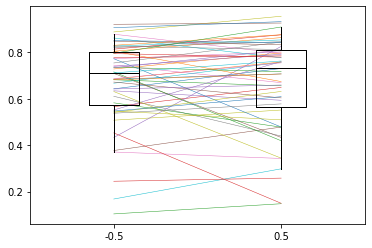

In [4]:
badAnimalList=BadLateRats

F=plt.figure(1)
ax=F.add_subplot(111)

_,SessionDict=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList)
y, nSessionPre, slicedPostData=plot_event_1on1(root,SessionDict, TaskParamToPlot=TaskParamToPlot[0],
                                               ax=ax, preSlice=preSlice, postSlice=postSlice);

In [ ]:
x=y[:,1]-y[:,0]
# x[y[:,0]<3.5]=np.nan
x=x[~ np.isnan(x)]
x_strapped=bootstrap(x,10000)
x_CI=np.percentile(x_strapped,[1,99])
print(x_CI)
print(stats.ttest_rel(y[:,1],y[:,0]))

In [ ]:
for i,animal in enumerate(SessionDict.keys()):
    print(i, animal,y[i,0],y[i,1],y[i,1]-y[i,0] ,sep='\t')
#     if y[i,1] < 0.4:
#         print(i, animal, y[i,0],y[i,1], sep='\t')


### maximum position

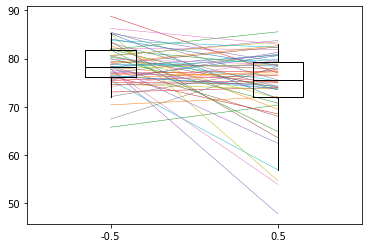

In [46]:
badAnimalList=[]
# badAnimalList=[*BadLateRats]
# for i,animal in enumerate(SessionDict.keys()):
#     if y[i,0] < 0.4:
#         badAnimalList.append(animal)

F=plt.figure(2)
ax=F.add_subplot(111)

_,SessionDict1=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList)
y1, nSessionPre1, slicedPostData1=plot_event_1on1(root,SessionDict1, TaskParamToPlot=TaskParamToPlot[1],ax=ax,
                                                  preSlice=preSlice, postSlice=postSlice);

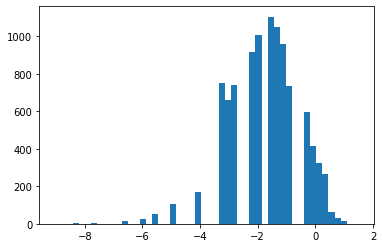

In [48]:
plt.hist(x_strapped,50);

In [47]:
x=y1[:,1]-y1[:,0]
# x[y[:,0]<3.5]=np.nan
x=x[~ np.isnan(x)]
x_strapped=bootstrap(x,10000, user_statistic=lambda x:np.median(x,axis=1))
x_CI=np.percentile(x_strapped,[1,99])
print(x_CI)
print(stats.ttest_rel(y1[:,1],y1[:,0]))

[-5.48612123  0.48902648]
Ttest_relResult(statistic=-3.5784287244030764, pvalue=0.0007222202278900597)


In [28]:
for i,animal in enumerate(SessionDict1.keys()):
    print(i, animal,y1[i,0],y1[i,1],y1[i,1]-y1[i,0] ,sep='\t')
#     if y[i,1] < 0.4:
#         print(i, animal, y[i,0],y[i,1], sep='\t')


0	Rat230	78.73528742822634	79.66923278955741	0.9339453613310695
1	Rat222	78.2854886206698	83.87992262800279	5.594434007332993
2	Rat224	65.76107774599743	72.09412414646012	6.333046400462692
3	Rat096	73.07366163592538	75.31431940355668	2.240657767631305
4	Rat162	85.2332724711813	80.1176252426765	-5.115647228504798
5	Rat251	83.5772048625272	70.13560940542398	-13.441595457103219
6	Rat299	82.09694776236168	81.66240554579483	-0.43454221656685377
7	Rat095	77.06679649916614	80.11801546950414	3.051218970337999
8	Rat229	74.6977335215324	76.71518394381529	2.0174504222828915
9	Rat304	75.55953088000706	70.93289951287278	-4.62663136713428
10	Rat131	75.78869768179455	79.55046735083204	3.7617696690374913
11	Rat308	76.73577304603945	77.5373968692301	0.8016238231906385
12	Rat263	81.91497517344804	76.1458622635645	-5.769112909883546
13	Rat137	75.47489592646922	78.24935201131991	2.774456084850698
14	Rat163	80.58108404573139	82.78405094851482	2.20296690278343
15	Rat144	79.41512801000529	79.49672239123105	0

## correlation with lesion size

In [ ]:
def late_lesion_correlation_with_size(root: str, SessionDict:dict, TaskParamToPlot:str,
                                      preSlice=slice(-5,None), postSlice=slice(0,5)):
    """
    SessionDict is the output of the function `event_detect`
    """
    
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                 SessionDict,
                                                 parameter=param,
                                                 redo=False,
                                                 TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre][~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:][~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    yPre =np.nanmean(slicedPreData ,axis=1)
    yPost=np.nanmean(slicedPostData,axis=1)

    size=[]
    behav=[]
    animals=[]
    for i,animal in enumerate(Results[TaskParamToPlot].keys()):
        try:
            Hist=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        behav.append(yPost[i]-yPre[i])
        size.append(Hist.lesion_size())
        animals.append(animal)
    
    return behav, size, animals

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }

    Profiles=(profile1,profile2)
    TaskParamToPlot=["Motor Sequence Score","Maximum Position"]
    preSlice=slice(-5,None)
    postSlice=slice(4,9)
    badAnimalList3=badAnimalList
    _,SessionDict=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList3)

    Behav, Size, Animals=late_lesion_correlation_with_size(root, SessionDict, TaskParamToPlot=TaskParamToPlot[1],
                                                           preSlice=preSlice, postSlice=postSlice)

In [ ]:
if "__file__" not in dir():
    color={'DS':'r','DMS':'g', 'DLS':'b', 'Control':'k'}
    
    ax=plt.subplot(111)
    for i,animal in enumerate(Animals):
        _,tag=lesion_type(root,animal)
        ax.scatter(Size[i], Behav[i], c=color[tag], label=tag);
        plt.annotate(animal[-3:], (Size[i],Behav[i]))
    ax.set_ylabel(TaskParamToPlot[1]);
    ax.set_xlabel('Lesion Size');
    handles = ax.get_legend_handles_labels()
    handles = [handles[0][-2], handles[0][-1], handles[0][-3],handles[0][-4]]
    ax.legend(handles, color.keys());
    leg = ax.get_legend()
    for i,c in enumerate(color.values()):
        leg.legendHandles[i].set_color(c)

# correlate speed with max pos

In [ ]:
def plot_correlation_behavior(root, animalList, profile, param, SessionRange=slice(-5,None), colors=None, ax=None):    
    x={} 
    y={}
    
    for animal in animalList:
        x[animal]=animal_learning_stats(root, animal, PerfParam=param[0], profile=profile, sessionSlice=SessionRange)
        y[animal]=animal_learning_stats(root, animal, PerfParam=param[1], profile=profile, sessionSlice=SessionRange)
        
    x=np.array(list(x.values()))
    y=np.array(list(y.values()))

    if ax is not None:
        if colors is None:
            colors=get_colors(len(animalList))
        
        r,p=scipy.stats.pearsonr(np.mean(x,1),np.mean(y,1))
        
        for i,_ in enumerate(animalList):
            ax.plot(x[i,:],y[i,:],'o',color=colors[i], markersize=2)

        P = np.poly1d(np.polyfit(x.flatten(), y.flatten(), 1))
        ax.plot(x.flatten(),P(x.flatten()),'k')

        maxX=np.max(x)
        minX=np.min(x)
        maxY=np.max(y)

        s='$r=$'+'$%+.2f$'%(r)+'\n'+'$p=$'+'$%.2e$'%(p)
        ax.text(minX, y=maxY, s=s, ha='left', va='top', fontsize=8)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_bounds(0,80)
        ax.spines['bottom'].set_bounds(minX,maxX+5)
        ax.set_ylim([0,80])

        ax.set_ylabel('% Correct trials')
        ax.set_xlabel('Displacement (cm)')
        ax.set_xlim([minX-2,maxX+2])

    
    return x,y

In [ ]:
if "__file__" not in dir():

    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }
    AnimalProfile={'Type':'Good',
                    'rewardType':'Progressive',
                    'initialSpeed':['10','0'],
                    'Speed':'10',
                    'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS',
                       'Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS',
                       'Late-Lesion_DMS-Sharp','Late-Lesion_DLS-Sharp','Late-Lesion_DS-Sharp']
                  }


    TaskParamToPlot=["Forward Running Speed","Maximum Position"]
    Slice=slice(-5,None)
    badAnimalList=set((*BadLateRats,'Rat223','Rat231','Rat144','Rat124','Rat218','Rat138','Rat251','Rat264','Rat249',
                        'Rat229','Rat220','Rat256','Rat260','Rat219','Rat305','Rat123','Rat215','Rat163','Rat141','Rat224','Rat230','Rat139',
                        'Rat217','Rat222'))
    animalList=batch_get_animal_list(root,AnimalProfile)
#     for animal in badAnimalList:animalList.remove(animal)
        
    x_,y_=plot_correlation_behavior(root, animalList, profile=AnimalProfile, 
                                          param=TaskParamToPlot, SessionRange=Slice,
                                          colors=None, ax=None)

In [ ]:
x=np.nanmedian(x_,1)
y=np.nanmedian(y_,1)
notNan=~np.logical_or(np.isnan(x),np.isnan(y))
# notNan=np.logical_and(notNan,y>66)
r,p=scipy.stats.pearsonr(x[notNan],y[notNan])
r,p=scipy.stats.spearmanr(x[notNan],y[notNan])
r,p

In [ ]:
plt.scatter(x[notNan],y[notNan]);
# plt.xlim([35,75])
# plt.ylim([50,85])
plt.ylabel('max pos');
plt.xlabel('vigor');
plt.title(f'all rats after learning,\n r={r},\n p={p}');
# for i,j,animal in zip(x,y,animalList):
#     if np.isnan(i) or np.isnan(j):continue
#     plt.text(i,j,animal);

# Speed in trials with low maxPos vs. high maxPos

In [ ]:
def back_trial_speed(data,high=65):
    seqObj = sequentialTrials(data,xFront=30, xBackMin=40)
    seqTrials,_ = seqObj._compute_sequential_trials()
    Speed=forwardRunningSpeed(data, minXBack=40, minXFront=30).compute()

    highTrial=np.array([trial for trial in seqTrials if data.position[trial].max()>high and trial in Speed.keys()])
    
    backSpeed=np.array([Speed[trial] for trial in highTrial])
    
    return np.nanmean(backSpeed)

def mid_trial_speed(data,low=50):
    seqObj = sequentialTrials(data,xFront=30, xBackMin=40)
    seqTrials,_ = seqObj._compute_sequential_trials()
    Speed=forwardRunningSpeed(data, minXBack=40, minXFront=30).compute()

    lowTrial =np.array([trial for trial in seqTrials if data.position[trial].max()<low and trial in Speed.keys()])
    
    midSpeed=np.array([Speed[trial] for trial in lowTrial])

    return np.nanmean(midSpeed)

In [ ]:
profile={'Type':'Good',
     'option': ['not used','AsymmetricLesion'],
     'rewardType':'Progressive',
     'initialSpeed':['10','0'],
     'Speed':'10',
     'Tag':['Early-Lesion_DS','Early-Lesion_DS-NoHab','Early-Lesion_DMS','Early-Lesion_DLS',
           'Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS',
           'Late-Lesion_DMS-Sharp','Late-Lesion_DLS-Sharp','Late-Lesion_DS-Sharp']
              }
param=[mid_trial_speed,back_trial_speed]

animalList=batch_get_animal_list(root,profile);

In [ ]:
x={} 
y={}
for animal in animalList:
    data=data_fetch(root,animal,profile, param, NbSession=slice(-5,None))
    y[animal]=np.nanmean(data[param[1].__name__])
    
    x[animal]=np.nanmean(data[param[0].__name__])

x=np.array(list(x.values()))
y=np.array(list(y.values()))


In [ ]:
F=plt.figure()
ax=F.add_subplot(111)

ax.boxplot(x=[x[~ np.isnan(x)],y[~ np.isnan(y)]],whis=[5,95],positions=[0,1],sym='',zorder=5)

for i,j in zip(x,y):
    if np.isnan(i) or np.isnan(j):
        continue
    ax.plot([0,1],[i,j],lw=.5)
    
ax.set_xticklabels(['mid trial','back trial']);
ax.set_ylabel('Speed(cm/s)');
ax.set_title('Each line one animal');

In [ ]:
CI=bootstrap(y-x,10000);

print(np.nanpercentile(CI1,[1,99]))